AC Remix:

The following code reads in data/raw/user_concepts.csv, data/raw/reverb_contributions.csv, and data/raw/comp_contributions.csv, which are the equalization, reverberation, and compression data sets, respectively, and recreates Figure 3 in the paper.

In [34]:

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))
stop_words = set(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/annie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from collections import Counter
import csv
from operator import itemgetter
import matplotlib
import pandas as pd

%matplotlib inline
plt.style.use('default')
font = {'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

# Read in csv files
file1 = 'audealize_data/eq_contributions.csv'
file2 = 'audealize_data/reverb_contributions.csv'
file3 = 'audealize_data/comp_contributions.csv'
# eq_reader = csv.reader(file1)
# rev_reader = csv.DictReader(file2)
# comp_reader = csv.DictReader(file3)

df_eq = pd.read_csv(file1, index_col=False)
df_eq.head()
# df_eq['descriptor']
df_eq['descriptor'] = df_eq['descriptor'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))
df_eq_sorted = df_eq.sort_values(by=['audio_id', 'ratings_consistency'], ascending=[True, False])

df_eq_sorted.head(10)
count_columns = sum(col.startswith('RSC') for col in df_eq_sorted.columns) #checking that we have all 40 bandds

# # # Equivalent to csv.DictReader(file2)
# df_reverb = pd.read_csv(file2, index_col=None)
# df_reverb.head()

# # # Equivalent to csv.DictReader(file3)
# df_comp = pd.read_csv(file3, index_col=None)
# df_comp.head()


/tmp/ipykernel_224473/145505688.py:27: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_eq = pd.read_csv(file1, index_col=False)


In [36]:
# Find descriptors in common
# EQ words
eq_desc = [word.lower() for word in df_eq['descriptor'] if word.strip().lower() not in stop_words]
print(eq_desc)


['hot', 'wet', 'slow', 'saucy', 'heavy', 'shrill', 'warm', 'chill', 'sharp', 'corn', 'warm', 'soft', 'apple', 'deep', 'scary', 'warm', 'oxygen', 'tinny', 'loud', 'flat', 'jarring', 'warm', 'prickly', 'crunchy', 'excitement', 'cold', 'cool', 'relaxing', 'cold', 'hard', 'light', 'cool', 'funky', 'bright', 'fast', 'flat', 'bright', 'heavy', 'crisp', 'pretty', 'hollow', 'soft', 'steep', 'classic', 'hard', 'cold', 'heavy', 'mellow', 'dark', 'tight', 'boom', 'sad', 'sunshine', 'fuzzy', 'carefree', 'woody', 'crunch', 'warm', 'sweet', 'soft', 'mournful', 'tinny', 'ralph', 'relaxing', 'soft', 'groovy', 'warm', 'warm', 'soothing', 'happy', 'damp', 'tinny', 'tiger', 'warm', 'tinny', 'greasy', 'warm', 'clear', 'warm', 'crisp', 'pleasant', 'cheerful', 'soft', 'cold', 'warm', 'creepy', 'warm', 'nice', 'punch', 'warm', 'soft', 'soft', 'pleasant', 'delightful', 'crisp', 'light', 'balanced', 'car', 'gradual', 'warm', 'calm', 'warm', 'pleasing', 'love', 'metallic', 'cat', 'loud', 'biting', 'serene', 'fa

In [8]:
# Reverb Words
# Extract rawwords column and split strings by comma + stopwords
reverb_rawwords = [word.lower() for sublist in df_reverb["rawwords"].str.split(',').dropna() for word in sublist if word.strip() not in ["", "none of the above"] and word.strip().lower() not in stop_words]
reverb_agreed = [word.lower() for sublist in df_reverb["agreed"].str.split(',').dropna() for word in sublist if word.strip() not in ["", "none of the above"] and word.strip().lower() not in stop_words]

# reverb_rawwords = [word for sublist in df_reverb["rawwords"].str.split(',').dropna() for word in sublist if word.strip() not in ["", "none of the above"]]
# reverb_agreed = [word for sublist in df_reverb["agreed"].str.split(',').dropna() for word in sublist if word.strip() not in ["", "none of the above"]]

# combining all rawwords and pre-agreed upon word descriptors
reverb_desc = list(reverb_rawwords + reverb_agreed)
# reverb_desc = list(set(reverb_rawwords + reverb_agreed))

print(reverb_rawwords)# Users were then asked to describe the resulting effect, first with as many words as they freely desired,
print(reverb_agreed)# then with descriptors they agreed with, chosen from a pool of previously contributed words.
print(reverb_desc)# non-unique list of words from rawwords+agreed


['live-concert', 'fantasy', 'dizzy', 'echoing', 'chrystal', 'angels', 'heaven', 'harp-strums', 'empty', 'spacious', 'softer', 'richer', 'exagerated', 'dramatic', 'spacious', 'hall', 'echo', 'vibrate', 'treble', 'mixed', 'multiple-effect', 'humongous', 'louder', 'bolder', 'large', 'church-bells', 'super', 'spacious', 'spacey', 'muffeled', 'distant', 'sad', 'disconnected', 'dark', 'organ', 'church', 'big', 'loud', 'echo', 'creepy', 'halloween', 'drums', 'distant', 'hollow', 'darker', 'lower-sounding', 'echo', 'simple', 'sweet', 'nicely-played', 'mild', 'tone', 'lucious', 'textured', 'harp-like', 'jazzy', 'super', 'indistinct', 'muffled', 'no-bass', 'lacking', 'warm', 'intense', 'jazzy', 'bold', 'enjoyful', 'loud', 'bass', 'echo', 'rhythm-boosting', 'keyboard-magic', 'deep', 'strong', 'echo-effect', 'vibrate', 'loud', 'big-church', 'voluminous', 'slight', 'minimal', 'soothing', ' orchestra', 'distant', 'hollow', 'eerie', 'alien', 'weak', 'strangled', 'car-speakers', 'horrible', 'mesmorizi

In [9]:
# Compression Words
# Extract rawwords column and split strings by comma

comp_rawwords = [word.lower() for sublist in df_comp["rawwords"].str.split(',').dropna() for word in sublist if word.strip() not in ["", "none of the above"] and word.strip().lower() not in stop_words]
comp_agreed = [word.lower() for sublist in df_comp["agreed"].str.split(',').dropna() for word in sublist if word.strip() not in ["", "none of the above"] and word.strip().lower() not in stop_words]

# combining all rawwords and pre-agreed upon word descriptors
comp_desc = list(comp_rawwords + comp_agreed)
# comp_desc = list(set(comp_rawwords + comp_agreed))

print(comp_rawwords) # Users were then asked to describe the resulting effect, first with as many words as they freely desired,
print(comp_agreed) # then with descriptors they agreed with, chosen from a pool of previously contributed words.
print(comp_desc) # non-unique list of words from rawwords+agreed

['quiet', 'unoticeable', 'vague', 'unheard', 'drumming', 'become', 'bit', 'louder', 'sound', 'expansive', 'recorded', 'larger', 'room', 'gentle', 'electric', 'eccentric', 'full', 'warm', 'deep', 'calm', 'soft', 'party', 'feedback', 'echoy', 'reverb', 'slippy', 'unclear', 'slidy', 'energetic', 'subtle', 'filter', 'effective', 'strong', 'clear', 'bass', 'fast', 'cool', 'clear', 'happy', 'energetic', 'guitar', 'active', 'breezy', 'broad', 'voluminous', 'glowing', 'expansive', 'strong', 'vigorous', 'warm', 'cloe-open', 'cloudy-sunny', 'full-moon', '3d-sound', 'spacious', 'stereo', 'live', 'sharp', 'intense', 'pausing', 'less', 'spacy', 'bad', 'sound-wrecker', 'feedback', 'lowered', 'volume', 'type', 'feedback', 'louder', 'reverb', 'big-church', 'pleasing', 'metallic', 'melodic', 'flowing', 'inviting', 'natural', 'pleasent', 'warm', 'no-change', 'similar', 'warm', 'fresh', 'sunny', 'clear', 'huge', 'spacious-stadium', 'bombastic', 'loud', 'slight', 'reverb', 'dampened.', 'sunny', 'go-go', '

In [37]:
eq_total = len(eq_desc)
rev_total = len(reverb_desc)
comp_total = len(comp_desc)
eq_count = dict(Counter(eq_desc))
rev_count = dict(Counter(reverb_desc))
comp_count = dict(Counter(comp_desc))

# Find Words unique to EQ
eq_unique = []
for desc in eq_desc:
    if desc not in reverb_desc and desc not in comp_desc:
        eq_unique.append(desc)
eq_unique = dict(Counter(eq_unique))
eq_unique = sorted(zip(eq_unique.keys(), eq_unique.values()), key=itemgetter(1), reverse = True)
print(f'Words unique to EQ: {eq_unique}')

print(eq_count)

# #
# # Find Words unique to Reverb
# rev_unique = []
# for desc in reverb_desc:
#     if desc not in eq_desc and desc not in comp_desc:
#         rev_unique.append(desc)
# rev_unique = dict(Counter(rev_unique))
# rev_unique = sorted(zip(rev_unique.keys(), rev_unique.values()), key=itemgetter(1), reverse = True)
# print(f'Words unique to Reverb: {rev_unique}')



# # Find Words unique to Compression
# comp_unique = []
# for desc in comp_desc:
#     if desc not in eq_desc and desc not in reverb_desc:
#         comp_unique.append(desc)
# comp_unique = dict(Counter(comp_unique))
# comp_unique = sorted(zip(comp_unique.keys(), comp_unique.values()), key=itemgetter(1), reverse = True)
# print(f'Words unique to Compression: {comp_unique}')


Words unique to EQ: [('claro', 33), ('fuerte', 18), ('frío', 13), ('caliente', 12), ('alto', 10), ('brillante', 6), ('ligero', 6), ('musica', 5), ('agudo', 5), ('bajo', 5), ('feliz', 4), ('divertido', 4), ('rápido', 4), ('elegante', 4), ('limpio', 4), ('oscuro', 4), ('duro', 4), ('feo', 4), ('hello', 3), ('hate', 3), ('bello', 3), ('áspero', 3), ('seco', 3), ('emocionante', 3), ('mojado', 3), ('perro', 3), ('asqueroso', 3), ('débil', 3), ('rico', 3), ('sucio', 3), ('lluvia', 3), ('grueso', 3), ('tibio', 3), ('armonioso', 3), ('cat', 2), ('chunky', 2), ('aggravating', 2), ('mischievous', 2), ('wistful', 2), ('agradable', 2), ('punchy', 2), ('sensual', 2), ('joven', 2), ('frenético', 2), ('dinámica', 2), ('camino', 2), ('potente', 2), ('amable', 2), ('miedoso', 2), ('nostálgico', 2), ('audaz', 2), ('agresivo', 2), ('yo', 2), ('húmedo', 2), ('cristalino', 2), ('puro', 2), ('pacifico', 2), ('terror', 2), ('dolor', 2), ('resplandeciente', 2), ('hero', 2), ('calmante', 2), ('estruendoso', 2)

In [ ]:
# Descriptors shared by pairwise effects
eq_rev = list(set(eq_desc).intersection(reverb_desc))
eq_comp = list(set(eq_desc).intersection(comp_desc))
rev_comp = list(set(reverb_desc).intersection(comp_desc))

er_freq = []
ec_freq = []
rc_freq = []
for desc in eq_rev:
    #eq_freq = list of (word, frequency(word) / total_word_count_EQdataset, frequency(word) / total_word_count_REVERBdataset
    er_freq.append((desc,float(eq_count[desc])/float(eq_total), float(rev_count[desc])/float(rev_total))) #freq of word in # of words in dataset
for desc in eq_comp:
    ec_freq.append((desc,float(eq_count[desc])/float(eq_total), float(comp_count[desc])/float(comp_total)))
for desc in rev_comp:
    rc_freq.append((desc,float(rev_count[desc])/float(rev_total), float(comp_count[desc])/float(comp_total)))


# print(er_freq) #eq_reverb
er_freq_sorted = sorted(er_freq, key=lambda x: max(x[1], x[2]), reverse=True)
print(er_freq_sorted) #eq_reverb_sorted  / sorted by highest frequency in either

# print(ec_freq) #eq_compression
ec_freq_sorted = sorted(ec_freq, key=lambda x: max(x[1], x[2]), reverse=True)
print(ec_freq_sorted) #eq_comp words / sorted by highest frequency in either

# print(rc_freq) #reverb_compression
rc_freq_sorted = sorted(rc_freq, key=lambda x: max(x[1], x[2]), reverse=True)
print(rc_freq_sorted) #eq_reverb_sorted  / sorted by highest frequency in either

# Words shared by EQ and Reverb
print(f' EQ n Reverb: {eq_rev}')
print(f' EQ n Comp: {eq_comp}')
print(f' Rev n Comp: {rev_comp}')

[('warm', 0.04015056461731493, 0.021786310517529214), ('distant', 0.0012547051442910915, 0.022259321090706732), ('cold', 0.02132998745294856, 0.0023650528658875902), ('loud', 0.01631116687578419, 0.02036727879799666), ('soft', 0.01819322459222083, 0.0070951585976627716), ('deep', 0.0037641154328732747, 0.015692821368948246), ('muffled', 0.0037641154328732747, 0.014802448525319978), ('suave', 0.014429109159347553, 5.564830272676683e-05), ('happy', 0.013801756587202008, 0.00464663327768503), ('bright', 0.01191969887076537, 0.002086811352253756), ('soothing', 0.01066499372647428, 0.0034501947690595437), ('harsh', 0.010037641154328732, 0.0027545909849749583), ('heavy', 0.009410288582183186, 0.002726766833611575), ('cool', 0.009410288582183186, 0.0051752921535893155), ('big', 0.0006273525721455458, 0.009321090706733445), ('smooth', 0.00878293601003764, 0.005119643850862549), ('tranquilo', 0.008155583437892095, 0.0001947690595436839), ('calm', 0.008155583437892095, 0.004090150250417362), ('h

In [ ]:
# Descriptors shared by all three effects
shared_desc = list(set(eq_desc).intersection(reverb_desc).intersection(comp_desc))
shared_count = dict()
shared_freq = []
for desc in shared_desc:
    shared_count[desc] = str(desc) + " {EQ Count: " + str(eq_count[desc]) + ", Reverb Count: " + str(rev_count[desc]) + ", Compression Count: " + str(comp_count[desc]) + "}"
    shared_freq.append((desc,float(eq_count[desc])/float(eq_total), float(rev_count[desc])/float(rev_total), float(comp_count[desc])/float(comp_total)))


<ipython-input-53-9d396834c6b5>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
<ipython-input-53-9d396834c6b5>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
<ipython-input-53-9d396834c6b5>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(zlabels)
<ipython-input-53-9d396834c6b5>:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


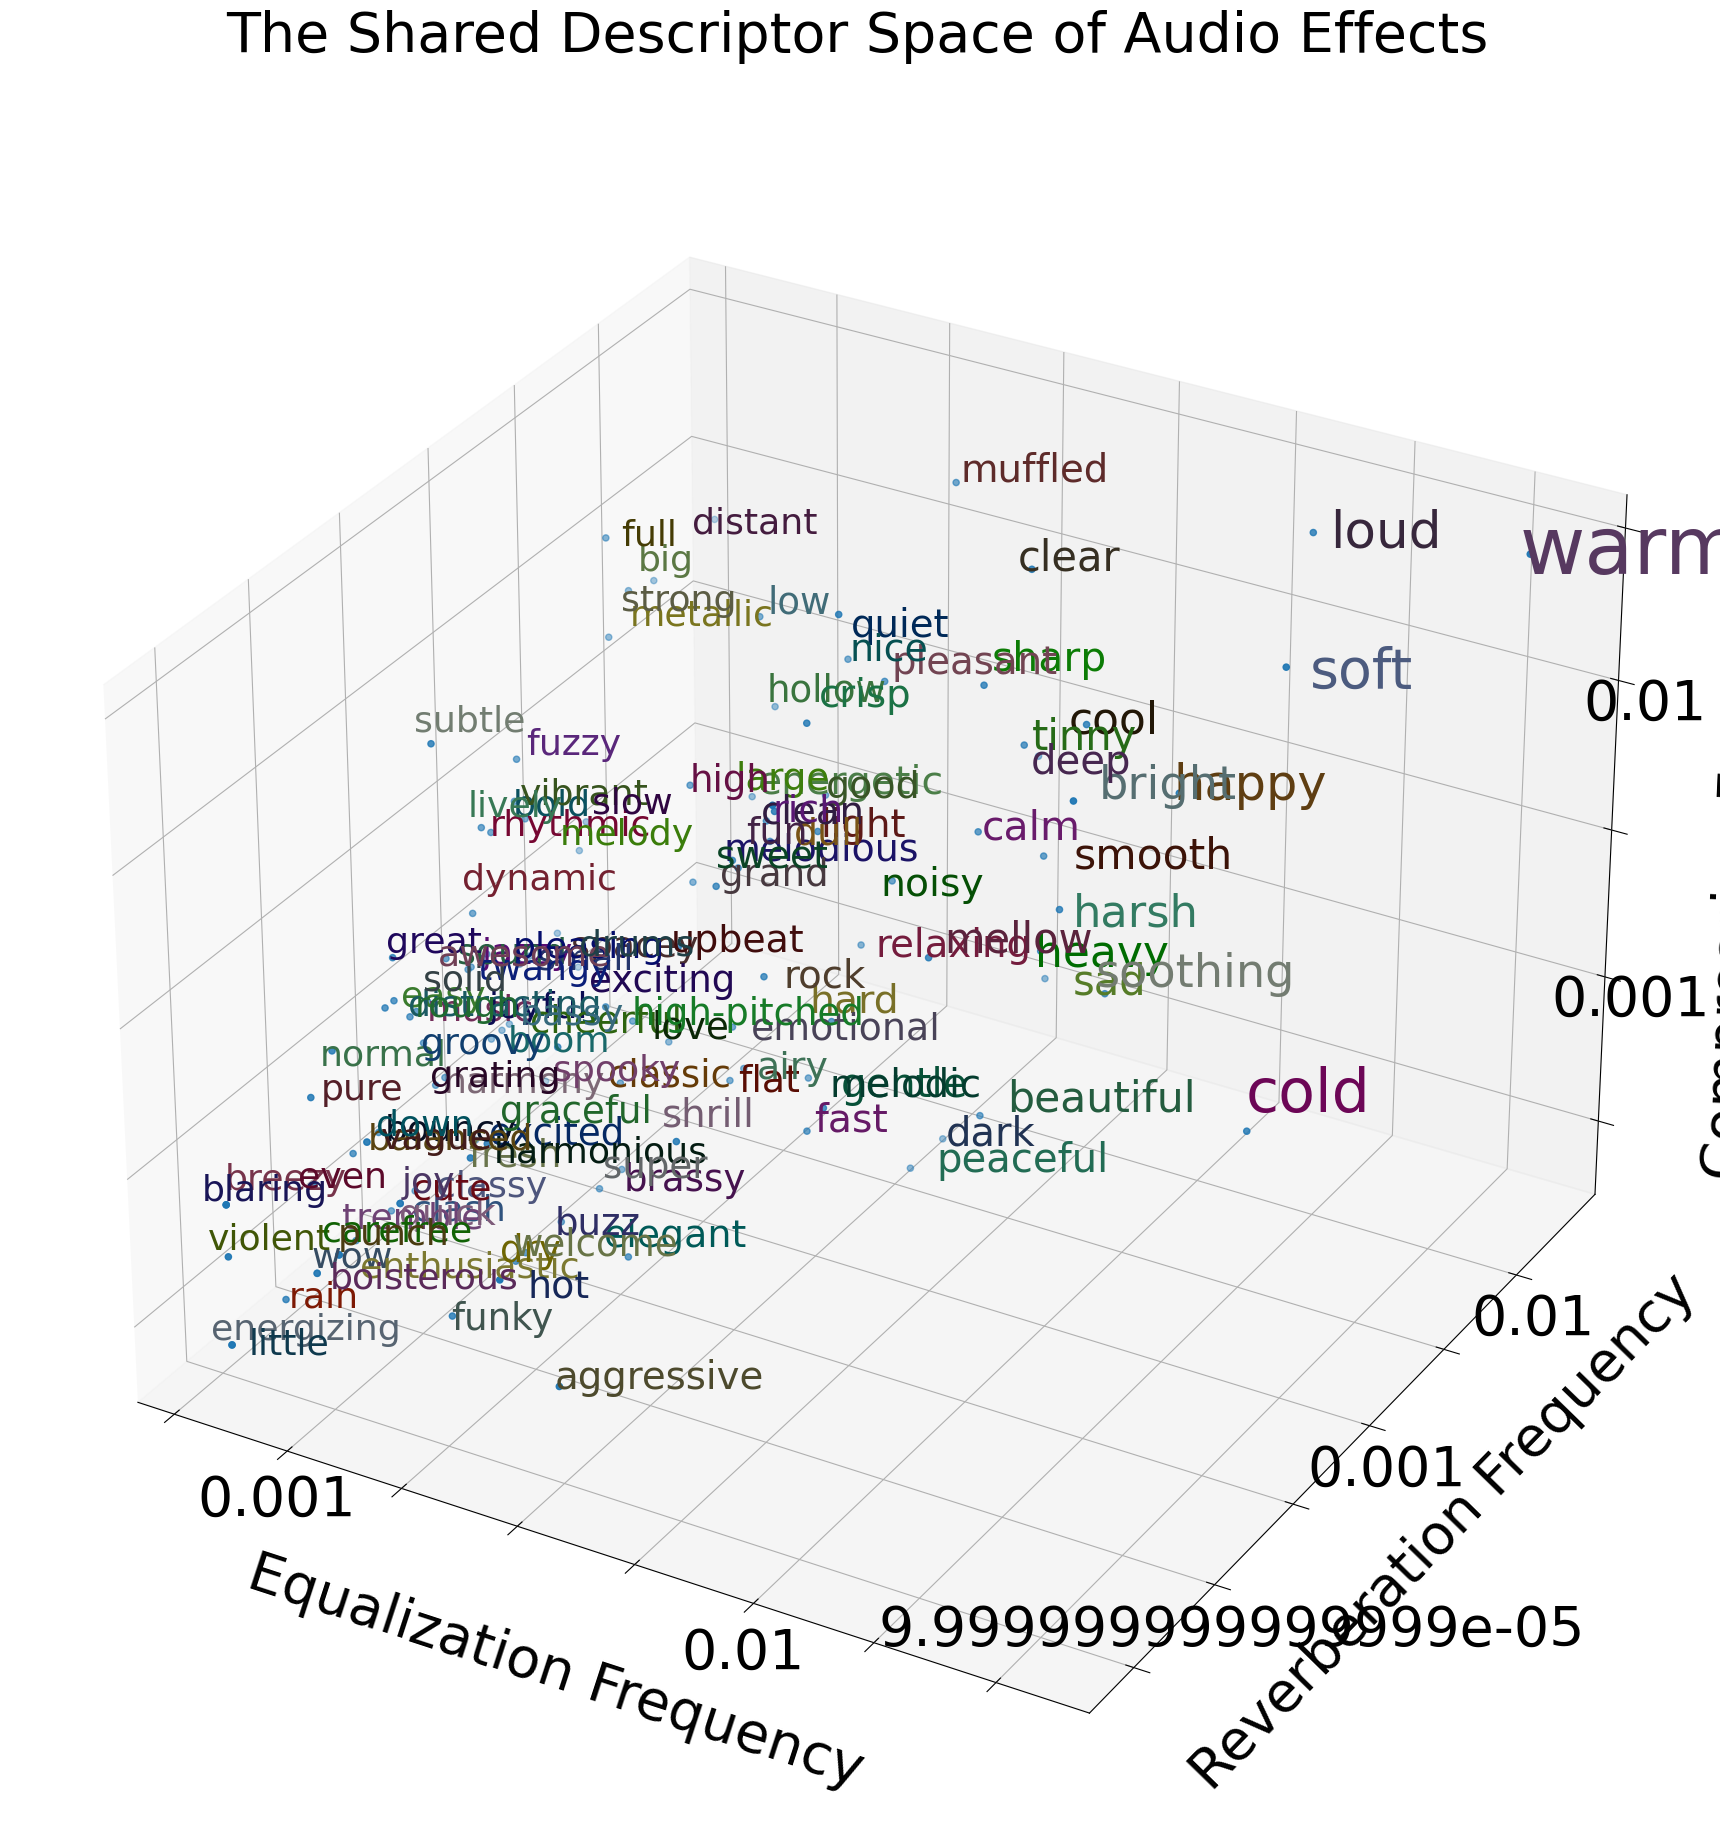

In [ ]:

enablelog = True
fig = plt.figure(figsize=(30,22))
ax = fig.add_subplot(111, projection='3d')

xs = [item[1] for item in shared_freq]
ys = [item[2] for item in shared_freq]
zs = [item[3] for item in shared_freq]
labels = [label[0] for label in shared_freq]

# xs = zip(*shared_freq)[1]
# ys = zip(*shared_freq)[2]
# zs = zip(*shared_freq)[3]
# labels = zip(*shared_freq)[0]
if enablelog:
    xs = np.log10(xs)
    ys = np.log10(ys)
    zs = np.log10(zs)
ax.scatter(xs, ys, zs, marker=None)

shared_freq_dict = {}
for d in shared_freq:
    shared_freq_dict[d[0]] = d[1]

max_freq = np.max([np.sum(d[1]) for d in shared_freq])

for x,y,z,i in zip(xs,ys,zs,labels):
    color = (np.random.rand()/2, np.random.rand()/2, np.random.rand()/2)
    fsize = 32*(np.sum(shared_freq_dict[i])/max_freq + .8)
    ax.text(x+(np.random.rand()-.5)/10,y+(np.random.rand()-.5)/10,z+ (np.random.rand()-.5)/10,i, size=fsize, color=color)


if enablelog:
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    zticks = ax.get_zticks()
    xlabels = [np.power(10, x) if x % 1 == 0 else '' for x in xticks]
    ylabels = [np.power(10, x) if x % 1 == 0 else '' for x in yticks]
    zlabels = [np.power(10, x) if x % 1 == 0 else '' for x in zticks]

    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.set_zticklabels(zlabels)

ax.set_xlabel('\nEqualization Frequency', linespacing=3.2)
ax.set_ylabel('\nReverberation Frequency', linespacing=3.2)
ax.set_zlabel('\nCompression Frequency',linespacing=3.2)

plt.tight_layout()
plt.title('The Shared Descriptor Space of Audio Effects\n')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
    item.set_fontsize(40)

plt.show()

In [ ]:
# Compression Words
comp_rawwords = []
comp_agreed = []
compuserid = []
comp_desc = []
for row in comp_reader:
    comp_rawwords.append(row["rawwords"])
    comp_agreed.append(row["agreed"])
    compuserid.append(row["userid"])

for i in range(len(comp_rawwords)):
    rawwords = comp_rawwords[i].split(',')
    for string in rawwords:
        if string != "" and string != "none of the above":
            comp_desc.append(string)
for i in range(len(comp_agreed)):
    agreed = comp_agreed[i].split(',')
    for string in agreed:
        if string != "" and string != "none of the above":
            comp_desc.append(string)

eq_total = len(eq_desc)
rev_total = len(reverb_desc)
comp_total = len(comp_desc)
eq_count = dict(Counter(eq_desc))
rev_count = dict(Counter(reverb_desc))
comp_count = dict(Counter(comp_desc))

# Find Words unique to EQ
eq_unique = []
for desc in eq_desc:
    if desc not in reverb_desc and desc not in comp_desc:
        eq_unique.append(desc)
eq_unique = dict(Counter(eq_unique))
eq_unique = sorted(zip(eq_unique.keys(), eq_unique.values()), key=itemgetter(1), reverse = True)
# print eq_unique


# Find Words unique to Reverb
rev_unique = []
for desc in reverb_desc:
    if desc not in eq_desc and desc not in comp_desc:
        rev_unique.append(desc)
rev_unique = dict(Counter(rev_unique))
rev_unique = sorted(zip(rev_unique.keys(), rev_unique.values()), key=itemgetter(1), reverse = True)
# print rev_unique


# Find Words unique to Compression
comp_unique = []
for desc in comp_desc:
    if desc not in eq_desc and desc not in reverb_desc:
        comp_unique.append(desc)
comp_unique = dict(Counter(comp_unique))
comp_unique = sorted(zip(comp_unique.keys(), comp_unique.values()), key=itemgetter(1), reverse = True)
# print comp_unique


# Pairwise Comparisons between effects
eq_rev = list(set(eq_desc).intersection(reverb_desc))
eq_comp = list(set(eq_desc).intersection(comp_desc))
rev_comp = list(set(reverb_desc).intersection(comp_desc))
er_freq = []
ec_freq = []
rc_freq = []
for desc in eq_rev:
    er_freq.append((desc,float(eq_count[desc])/float(eq_total), float(rev_count[desc])/float(rev_total)))
for desc in eq_comp:
    ec_freq.append((desc,float(eq_count[desc])/float(eq_total), float(comp_count[desc])/float(comp_total)))
for desc in rev_comp:
    rc_freq.append((desc,float(rev_count[desc])/float(rev_total), float(comp_count[desc])/float(comp_total)))

# Plotting the descriptors shared by all three effects
shared_desc = list(set(eq_desc).intersection(reverb_desc).intersection(comp_desc))
shared_count = dict()
shared_freq = []
for desc in shared_desc:
    shared_count[desc] = str(desc) + " {EQ Count: " + str(eq_count[desc]) + ", Reverb Count: " + str(rev_count[desc]) + ", Compression Count: " + str(comp_count[desc]) + "}"
    shared_freq.append((desc,float(eq_count[desc])/float(eq_total), float(rev_count[desc])/float(rev_total), float(comp_count[desc])/float(comp_total)))


enablelog = True
fig = plt.figure(figsize=(30,22))
ax = fig.add_subplot(111, projection='3d')
xs = zip(*shared_freq)[1]
ys = zip(*shared_freq)[2]
zs = zip(*shared_freq)[3]
labels = zip(*shared_freq)[0]
if enablelog:
    xs = np.log10(xs)
    ys = np.log10(ys)
    zs = np.log10(zs)
ax.scatter(xs, ys, zs, marker=None)

shared_freq_dict = {}
for d in shared_freq:
    shared_freq_dict[d[0]] = d[1]

max_freq = np.max([np.sum(d[1]) for d in shared_freq])

for x,y,z,i in zip(xs,ys,zs,labels):
    color = (np.random.rand()/2, np.random.rand()/2, np.random.rand()/2)
    fsize = 32*(np.sum(shared_freq_dict[i])/max_freq + .8)
    ax.text(x+(np.random.rand()-.5)/10,y+(np.random.rand()-.5)/10,z+ (np.random.rand()-.5)/10,i, size=fsize, color=color)


if enablelog:
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    zticks = ax.get_zticks()
    xlabels = [np.power(10, x) if x % 1 == 0 else '' for x in xticks]
    ylabels = [np.power(10, x) if x % 1 == 0 else '' for x in yticks]
    zlabels = [np.power(10, x) if x % 1 == 0 else '' for x in zticks]

    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.set_zticklabels(zlabels)

ax.set_xlabel('\nEqualization Frequency', linespacing=3.2)
ax.set_ylabel('\nReverberation Frequency', linespacing=3.2)
ax.set_zlabel('\nCompression Frequency',linespacing=3.2)

plt.tight_layout()
plt.title('The Shared Descriptor Space of Audio Effects\n')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
    item.set_fontsize(40)

plt.show()

### Getting top words by frequency

In [38]:
#EQ
eq_file = 'audealize_data/eq_contributions.csv'
df_eq = pd.read_csv(eq_file, index_col=False)
df_eq.head()
# count_columns = sum(col.startswith('RSC') for col in df_eq_sorted.columns) #checking that we have all 40 bandds

df_eq['descriptor'] = df_eq['descriptor'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))
df_eq_sorted = df_eq[df_eq['audio_id'] == 'English'].sort_values(by='ratings_consistency', ascending=False)

eq_desc = [word.lower() for word in df_eq_sorted['descriptor'] if word.strip().lower()]
eq_count = dict(Counter(eq_desc))
# eq_unique = sorted(zip(eq_count.keys(), eq_count.values()), key=itemgetter(1), reverse = True)
eq_unique = sorted(eq_count.items(), key=lambda item: item[1], reverse=True)
print(eq_unique[:10])

df_eq_unique = pd.DataFrame(eq_unique[:10], columns=['Descriptor', 'Count'])
print(df_eq_unique)

[('warm', 64), ('cold', 34), ('soft', 29), ('loud', 26), ('happy', 22), ('bright', 19), ('soothing', 17), ('harsh', 16), ('heavy', 15), ('cool', 14)]
  Descriptor  Count
0       warm     64
1       cold     34
2       soft     29
3       loud     26
4      happy     22
5     bright     19
6   soothing     17
7      harsh     16
8      heavy     15
9       cool     14


/tmp/ipykernel_224473/1344614524.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_eq = pd.read_csv(eq_file, index_col=False)
